  ## DATA SCIENCE CHALLENGE SOLUTION BI

Installer cette librairie si necessaire (peut remplacer sklearn.externals.joblib)

In [ ]:
!pip install joblib

In [14]:
### Import differents librairies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import  make_scorer, mean_squared_error
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor
from sklearn.preprocessing  import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals import joblib 

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Le warning veut simplement dire que le module de sauvegarde de modele de sklearn ne sera plus valable
à la version 0.23.

<b>flight.csv</b> 
<br> Le fichier contient 112.000 lignes au format csv. Les données concernent <b> le temps de vol</b>,
<b> le nombre de passagers</b>, <b>l'id</b> du vol qui est unique.


In [15]:
#### lire le fichier sur les données de vols
flights = pd.read_csv('flights.csv')


<b> weather.csv</b>
<br> Le fichier contient environs 7600 lignes representant les conditions metereologiques du vol
c'est à dire <b> la temperature</b>, <b> la vitesse du vent</b>, <b> les donnees de precipitations</b>
pour chaque jour de vol


In [16]:
# lire le fichier de temperatures
weather = pd.read_csv('weather.csv')

In [17]:
# apercu des premieres lignes 
weather.head()

,date,temperature,windSpeed,precipitation
0,1995-01-01,0.185703,3.152788,4.090158
1,1995-01-02,2.093932,0.982883,1.429355
2,1995-01-03,0.242077,2.429390,4.202771
3,1995-01-04,1.734953,0.606430,11.869286
4,1995-01-05,-3.544882,0.255810,4.960454


In [18]:
#apercu des premieres lignes
flights.head(10)

,id,date,number_passengers,duration
0,0,1995-01-01,38.0,2.008839
1,1,1995-01-01,34.0,1.935641
2,2,1995-01-01,NaN,2.025223
3,3,1995-01-01,NaN,2.066374
4,4,1995-01-01,NaN,1.048679
5,5,1995-01-01,NaN,1.029462
6,6,1995-01-02,37.0,2.051586
7,7,1995-01-02,39.0,2.017713
8,8,1995-01-02,NaN,1.985811
9,9,1995-01-02,38.0,1.968442


On remarque la presence de <b>NaN</b> dans les données notamment dans la 
columne <b>number_passengers</b>.

### 1.3 POSONS LE PROBLEME

##### 1. Créeons un unique dataset à partir en ajoutant les données journalières de temperature au dataset flights

In [19]:
# Ajoutons les données climatologiques du vol au dataset flights
flights = flights.merge(weather, left_on=['date'], right_on=['date'], how='left')


In [20]:
# Ajoutons les données climatologiques du vol au dataset flights
flights2 = flights.merge(weather, left_on=['date'], right_on=['date'], how='right')

Analysons un peu le nouveau dataset crée.

In [21]:
# getting infos about columns of the dataset
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112104 entries, 0 to 112103
Data columns (total 7 columns):
id                   112104 non-null int64
date                 112104 non-null object
number_passengers    56216 non-null float64
duration             112104 non-null float64
temperature          112104 non-null float64
windSpeed            112104 non-null float64
precipitation        112104 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 6.8+ MB


Toutes les variables sont de type numériques ici, il n'ya pas de variables categorielles.
<br> De plus, seule la columne <b>number_passengers</b> contient des données manquantes et
en quantité importante (environ <b>49%</b>)

In [22]:
# Apercu du ratio de données manquantes par columne
flights.isnull().mean()

id                   0.000000
date                 0.000000
number_passengers    0.498537
duration             0.000000
temperature          0.000000
windSpeed            0.000000
precipitation        0.000000
dtype: float64

Comme signifié plus haut, la columne <b>number_passengers</b> contient
environ <b>0.498</b> de données manquantes soit un peu plus de <b>49%</b>.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1e5f66b00>,
      dtype=object)

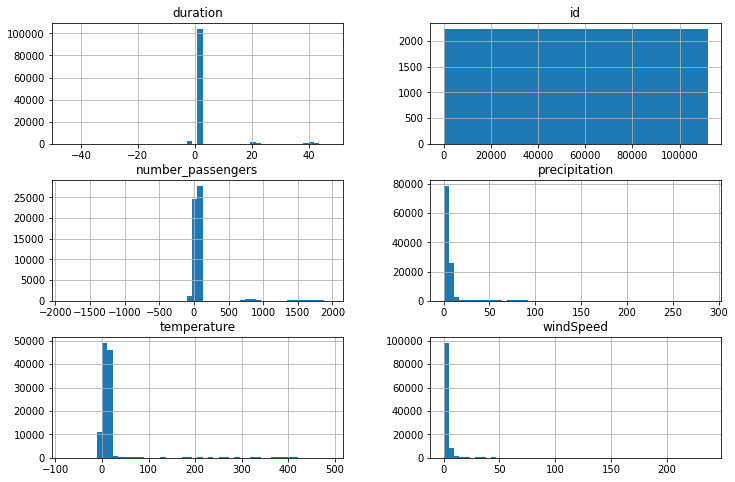

In [23]:
# Visualisons quelques columnes interessantes de notre dataset
flights.hist(bins=50, figsize=(12,8))

L'analyse de ces histogrammes nous permet de tirer plusieurs informations.
<ul>
<li> Premierement la variable <b>number_passengers</b>  a des élements negatifs, ce qui de prime abord 
ne semble pas très logique.<br> La même remarque se fait sur la columne <b> duration </b>.
</ul> 
Peut être s'agit t'il d'une question de <b>signe</b> et prendre la valeur absolue resoudrait le problême
mais aucune information supplémentaire n'est donnée dans la documentation. Nous n'allons donc pas opter
pour cette opération.
<br> Ce problème peut aussi être lié à un problème de capteurs defectueux. Dans ce cas, il faudrait enlever les donnéees correspondates au dataset.


#### Effectuons du feature_engineering sur la variable date
Il s'agit ici d'extraire d'autres caracteristiques de la variable <b>date</b>
pouvant servir ici à entrainer un modèle ou pouvant nous aider à repondre à une
problematique à l'aide de visualisations.

In [24]:
def convert_to_day(day_ind):
    """ 
    avoir le nom du jour en se
    basant sur son index
    INPUT
    -day_ind: index du jour 
    OUTPUT
    - return nom du jour.
    """
    #assert day_ind>7, 'error incorrect day'
    if day_ind==0:
        return 'Mon'
    elif day_ind==1:
        return 'Tues'
    elif day_ind==2:
        return 'Wednes'
    elif day_ind==3:
        return 'Thurs'
    elif day_ind==4:
        return 'Fri'
    elif day_ind==5:
        return 'Satur'
    elif day_ind==6:
        return 'Sun'

def is_week_end_day(day_ind):
    """ 
    retourne 0 s'il ne s'agit
    pas d'un week end, sinon
    retourne 1
    INPUT
    -day_ind: nom du jour 
    OUTPUT
    - return 0 ou 1.
    """
    #assert day_ind>7, 'error incorrect day'
    if day_ind=='Satur' or day_ind=='Sun':
        return 1
    else:
        return 0

Ces fonctions peuvent être utiles  dans le sens ou elles peuvent aider  à repondre aux questions
suivantes:
<ul>
<li> Y'a t'il plus de vols en semaines qu'en week end?
<li> Y'a t'il plus de vols un jour en particulier?
</ul>

On continue l'extraction de features de l'element date en
selectionnant cette fois ci l'année, le mois, le jour.

In [25]:
# mettre la date au format datetime
flights['date'] = pd.to_datetime(flights['date'],
                                 format='%Y-%m-%d')
# ajout du jour dans le dataset
flights['day'] = flights['date'].dt.day
# ajout du mois dans le dataset
flights['month'] = flights['date'].dt.month
#ajout de l'année dans le dataset
flights['year'] = flights['date'].dt.year
# ajout du jour dans le dataset
flights['day_name'] = flights['date'].dt.\
                      weekday.map(convert_to_day)
# dire s'il s'agit d'un jour de week end ou pas
flights['is_week_end'] = flights['day_name'].\
                         map(is_week_end_day)
# ajouter la saison du vol
season = ['winter', 'printemps', 'ete', 'automne']
# attribuer une saison à chaque mois
month_season = np.asarray([(month%12 + 3)//3 
                           for month in range(1, 13)])
month_season = np.asarray([season[ind-1] 
                           for ind in month_season])
month_season = dict(zip(range(1,13), month_season))
# ajouter la saison au dataset
flights['season'] = flights['month'].\
                    map(lambda x:month_season[x])

### <b></b> Detectons les eventuels valeurs abberantes dans les variables.
Les valeurs abberantes <b>outliers</b> d'une variable aléatoire represente des valeurs trop ecartés du
groupe de points (distribution de la variables).
<br> Ils peuvent être liés à des erreurs dans les données (défaut de capteurs ou erreur humaine) et
d'autres part à des cas exceptionnels pouvant se produire (étude de comportement frauduleux ou d'évènements
rares. Il est donc important d'en tenir compte dans l'analyse.
Plusieurs algorithmes existent pour la detection des <b>outliers</b>.
<br> Nous allons ici utiliser la méthode de <b>Tukey</b> basé sur les quantiles.

In [26]:
def detect_outliers(data, column):
    """
    retourne les index des outliers
    de data[column]
    INPUT
    -dataframe: dataframe 
    -column: une des columnes de data
    OUTPUT
    - return indices des outliers
    dans data[column].
    """
    # les indices seront stockés dans un set
    indices_outliers = {}
    # verifier que la columne fait partie de data
    assert column in data.columns, 'columne inconnue'
    # verifier si la columne est numérique
    assert np.issubdtype(data[column].dtype, np.number),\
          'column with no numeric values'
    # 1er quantile
    Q1 = data[column].quantile(0.25)
    #3eme quantile
    Q3 = data[column].quantile(0.75)
    # calcule l'interquantile
    IQ = Q3 -Q1
    # borne  interquantile
    outlier_step = 1.5*IQ
    #borne inférieure de la distribution
    cond1 = data[column]< Q1-outlier_step
    #borne supérieure de la distribution
    cond2 = data[column]> Q3 + outlier_step
    # retourner la liste des outliers
    outlier_indices = list(data[(cond1 | cond2)].index)
    return set(outlier_indices)
    


Iterons sur l'ensemble des columnes à l'exception de <b> date</b> afin de 
detecter d'eventuels outliers et les supprimer.

In [27]:
# instancier un set ou l'on rangera les index des columns
# des outliers
all_outliers = set()
# definit la liste des columnes sur lesquels nous travaillerons
column_of_interest = ['number_passengers', 'duration',
                      'temperature', 'windSpeed',
                      'precipitation'
                     ]
for col in flights.columns:
    if col in column_of_interest:
        # ajouter seulement les index non deja presents
        all_outliers.update(detect_outliers(flights, col))
        

In [28]:
#remove all outliers values from all differents columns
flights_no_outliers = flights.drop(all_outliers, axis=0).\
                      reset_index()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1aeba2be0>,
      dtype=object)

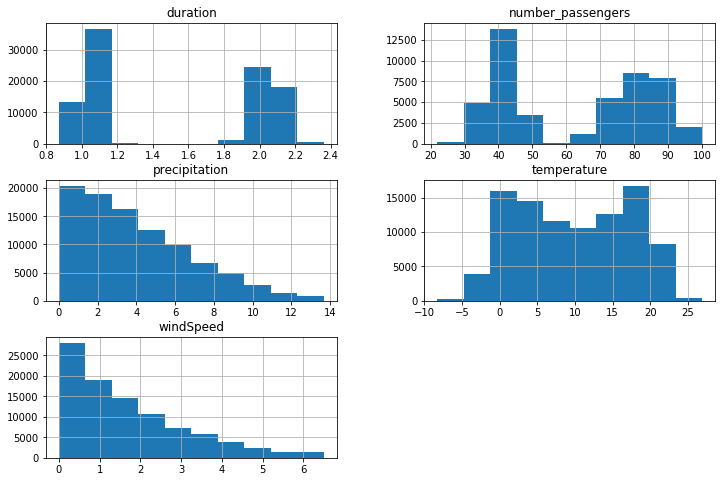

In [29]:
flights_no_outliers[column_of_interest].hist(figsize=(12, 8))

Une analyse de ces histogrammes nous revèle que:
<br>Les valeurs negatives contenues dans les variables <b>duration</b> and <b> number_passengers</b> 
ont disparu. Ce qui prouve qu'il s'agissait donc de <b> valeurs aberrantes</b>.
<br> Notre jeu de données est donc ici debarassé de toute valuers superflu.

In [30]:
# quantité de données retirés du dataset
rate = (1-(len(flights_no_outliers)/len(flights)))*100
print('rate removed data {}%'.format(rate))

rate removed data 15.393741525726112%


Environ <b>15%</b> du jeu de données a été retiré, ce qui correspond à une quantité
non negligeable. Cependant, il s'agissait d'outliers

### 2. Prediction du nombre de passagers 
Avec le nouveau dataset à disposition <b>flights_no_outliers</b>, nous allons
essyer de predire le nombre de passagers du vol dans les cas ou cette donnée est manquante.
<br> En effet, nous avons remarqué plus haut qu'environ <b>49.8%</b> des vols ne contiennent
pas la donnée sur le nombre de passagers.

In [31]:
# creer un dataset composer uniquement des cas ou la donnée passager manque
flights_missing_pessengers = flights_no_outliers.\
                             query('number_passengers!=number_passengers')

# recueillir les index de ces cas 
index_missing_passengers = flights_missing_pessengers.index
# enlever ces elements de notre dataset depourvu des outliers
flights_no_outliers = flights_no_outliers.\
                      drop(index_missing_passengers, axis=0).reset_index()

In [32]:
# verifions notre dataset
flights_no_outliers.isnull().mean()


level_0              0.0
index                0.0
id                   0.0
date                 0.0
number_passengers    0.0
duration             0.0
temperature          0.0
windSpeed            0.0
precipitation        0.0
day                  0.0
month                0.0
year                 0.0
day_name             0.0
is_week_end          0.0
season               0.0
dtype: float64

Afin de predire la variable <b>missing_passengers</b>, nous utiliserons le dataset
<i> flights_no_outliers</i>. Dans le cadre de la prediction (utilisation d'un modèle
de regression), nous procederons à la création d'un jeu d'entrainement et d'un jeu
de test avec les données de vol. Cependant un échantillonnage aléatoire des vols pour
ces différents jeu peut introduire un biais dans nos données (variété des jeu de donnés
impactés). Afin de pallier à ce problème, nous procederons à un échantillonnage <b>stratifié</b>
en categorisant la variable <b>number_passengers</b>. Cette categorisation s'appuie sur une 
observation de l'histogramme plus <b>haut</b>. On y observe deux groupes distincts.
<br> Nous allons donc crée ici deux categories (-53 passagers, +53 passagers)

In [33]:
# créeons une variable rang qui va nous dire à quelle categorie appartient la 
# variable suivant le nombre de passagers.
flights_no_outliers['rank'] = np.ceil(
                                flights_no_outliers['number_passengers']/53
                              )


In [71]:
flights_no_outliers

,level_0,index,id,date,number_passengers,duration,temperature,windSpeed,precipitation,day,month,year,day_name,is_week_end,season,rank
0,0,0,0,1995-01-01,38.0,2.008839,0.185703,3.152788,4.090158,1,1,1995,Sun,1,winter,1.0
1,1,1,1,1995-01-01,34.0,1.935641,0.185703,3.152788,4.090158,1,1,1995,Sun,1,winter,1.0
2,6,6,6,1995-01-02,37.0,2.051586,2.093932,0.982883,1.429355,2,1,1995,Mon,0,winter,1.0
3,7,7,7,1995-01-02,39.0,2.017713,2.093932,0.982883,1.429355,2,1,1995,Mon,0,winter,1.0
4,9,9,9,1995-01-02,38.0,1.968442,2.093932,0.982883,1.429355,2,1,1995,Mon,0,winter,1.0
5,10,10,10,1995-01-02,66.0,1.020850,2.093932,0.982883,1.429355,2,1,1995,Mon,0,winter,2.0
6,12,12,12,1995-01-03,34.0,2.056277,0.242077,2.429390,4.202771,3,1,1995,Tues,0,winter,1.0
7,14,14,14,1995-01-03,67.0,1.056029,0.242077,2.429390,4.202771,3,1,1995,Tues,0,winter,2.0
8,16,16,16,1995-01-03,75.0,1.044218,0.242077,2.429390,4.202771,3,1,1995,Tues,0,winter,2.0
9,17,17,17,1995-01-03,82.0,1.166688,0.242077,2.429390,4.202771,3,1,1995,Tues,0,winter,2.0


Effectuons ici un échantillonnage stratifié pour les jeux de test et d'apprentissage 
avec 20% des données destinés à tester notre modèle.

In [72]:
#definir un ratio pour le jeu d'entrainement/test
ratio_test = 0.2
# effectuer le split pour nos jeux de données
split = StratifiedShuffleSplit(n_splits=1,
                               test_size=ratio_test,
                               random_state=42)
split_elts = split.split(flights_no_outliers,
                         flights_no_outliers['rank'])
for train_index, test_index in split_elts:
    strat_train_set = flights_no_outliers.loc[train_index, :]
    strat_test_set = flights_no_outliers.loc[test_index, :]

Verifions la proportion de rank dans les differents jeux de données.

In [73]:
# repartition dans le jeu de données total
rep_total = flights_no_outliers['rank'].value_counts()\
            /len(flights_no_outliers)
print('repartition jeu de données initiale:\n{}'.format(rep_total))
# repartition dans le jeu d'entrainement
rep_train = strat_train_set['rank'].value_counts()\
            /len(strat_train_set)
print('repartition jeu entrainement initiale:\n{}'.format(rep_train))
# repartition dans le jeu de test
rep_test = strat_test_set['rank'].value_counts()\
          /len(strat_test_set)
print('repartition jeu test initiale:\n{}'.format(rep_test))

repartition jeu de données initiale:
2.0    0.531295
1.0    0.468705
Name: rank, dtype: float64
repartition jeu entrainement initiale:
2.0    0.531306
1.0    0.468694
Name: rank, dtype: float64
repartition jeu test initiale:
2.0    0.531253
1.0    0.468747
Name: rank, dtype: float64


Nos jeux de données d'apprentissage et de test contiennent les bonnes proportions de données.

Afin de prédire les données manquantes, il nous faut choisir un algorithme de regression.
<br> Plusieurs choix sont possibles (réseaux de neurones, arbre de decision, xgboost, 
random forest.
<br> Afin d'arriver au resultat le plus proche possible de la réalité, nous utiliserons ici
un algorithme <b>ensembliste</b> pour leur robustesse et leur fiabilité.
<br> En effet , l'erreur que comment un algorithme classique de machine learning est 
d'une part lié aux données (possible bruit présent) et d'autre part au classifieur
que l'on choisit. Combiner des classifieurs permet ici de reduire cette dernière erreur
et d'arriver à un resultat finale beaucoup plus robuste.
<br> Nous utiliserons ici un modèle de type <b>random forest</b> pour la regression.
Afin de parvenir au meilleur modèle, nous allons procéder à la recherche des 
<b>hyperparamètres</b> du modèle donnant les meilleurs performances avec comme
critère de decision la <b>rmse (racine carrée de l'erreur quadratique moyenne)</b>
Une validation croisée sera effectué pendant la phase de selection des hyperparamètres
(KFolding=5)=> jeu de données divisé en 5 part égales, entrainement sur 4/5 des parts
et test sur la dernière et ainsi de suite.
<br> Concernant les hyperparamètres, nous nous concentrerons ici sur deux d'entre eux
<ul>
<li> <b>n_estimators</b> : nombre d'arbres de decisions à utiliser ici
<li> <b>max_features</b> : le nombre  de caracteristiques à considerer 
pour le meilleur split.
<li> <b>max_depth</b>: profondeur maximum de l'arbre
<li> <b> min_samples_leaf</b>: nombre minimum d'observations pour splitter un noeud interne

</ul>

In [74]:
#### Evaluation du modèle

def evaluate_model(modele, train_set, train_label):
    """
    prend en entrée un modèle random forest
    et affine ses paramètres.
    INPUT
    -modele: modele random forest 
    -train_set: jeu d'entrainement à 
    utiliser
    OUTPUT
    - return le meilleur modèle
    """
    #  hyperparameters to tune
    params = [{'n_estimators':[100, 200],
               'max_features' : [0.7, 'sqrt', 'auto'],
               'max_depth':[7, 9],
               'min_samples_leaf':[2, 3, 5]
              }
             ]
    predictor = make_scorer(mean_squared_error,
                            squared=True)
    rf_random = GridSearchCV(estimator = modele,
                             param_grid = params,
                             cv = 5,
                             verbose=4,
                             n_jobs = -1)
    
    # entrainer l'arbre de foret aleatoires
    rf_random.fit(train_set, train_label)
    grid_search_result = rf_random.cv_results_    
    print('best params {} \n'.format(rf_random.best_params_))
    print('best score {} \n'.format(rf_random.best_score_))
    # selectionner le meilleur modele à l'issu du GridSearchCV
    chosen_model = rf_random.best_estimator_
    return chosen_model, grid_search_result


In [75]:
# enlever les variables non necessaires pour la prediction
strat_train_label = strat_train_set['number_passengers'].values
strat_test_label = strat_test_set['number_passengers'].values

column_to_remove = ['level_0', 'index', 'id',
                    'date', 'season', 'rank',
                    'number_passengers', 'day_name'
                   ]
column_to_remove = set(column_to_remove).\
                   intersection(strat_train_set.columns)
strat_train_set = strat_train_set.drop(column_to_remove, axis=1)
strat_test_set = strat_test_set.drop(column_to_remove, axis=1)


Le reglage des hyperparametres du random forest prend <b>9 min</b> sur mon PC
(4 coeurs, 8GO RAM).<br>J'ai donc sauvegardé le modèle il ne faut plus que le charger (pour aller 
plus vite)

In [76]:
forest_reg = joblib.load("random_forest_model.pkl")

Si vous voulez lancer le reglage des hyperparametres vous même,
lancer la case suivante (prend 9 minutes sur mon PC)

In [ ]:

forest_reg = RandomForestRegressor(random_state=42)
# tune parameters of the chosen dataset
forest_reg, grid_search_results = evaluate_model(forest_reg,
                                                 strat_train_set,
                                                 strat_train_label)


Text(0.5,1,'repartion erreur sur le jeu de test')

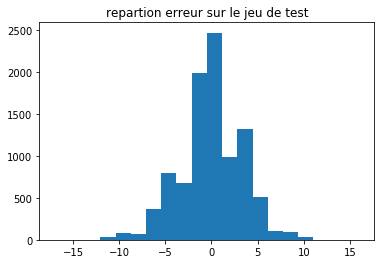

In [77]:
predictions = np.round(forest_reg.predict(strat_test_set))
# visualisation en terme d'histogramme des erreurs commises par 
# notre classifieur
plt.hist(strat_test_label-predictions, bins=20)
plt.title('repartion erreur sur le jeu de test')

L'histograme de la courbe de l'erreur <b>RMSE</b> sur le jeu de données, s'apparente à une
gaussienne centrée en 0. 
<br> Approximativement 95% des valeurs sont entre 
<b>moyenne-2 sigma</b> et <b>moyenne+2*sigma</b> ou sigma represente l'ecart type.
Ce qui signifie sur environ 68% des données de test ici, nous avons effectués au maximum une erreur
de +/- 5 passagers, ce qui est correcte.

In [78]:
#print mean square error on test set
rmse = print('rmse on test set {}'.\
             format(mean_squared_error(strat_test_label,
                                       predictions,
                                       squared=True)))

rmse on test set 11.37955667612144


In [42]:
np.corrcoef(strat_test_label,
           predictions)

array([[1.        , 0.98750217],
       [0.98750217, 1.        ]])

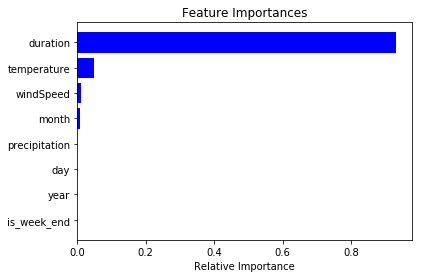

In [41]:
# computing features importances
importances = forest_reg.feature_importances_
features_col = strat_train_set.columns
indices = np.argsort(importances)[-len(importances):]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_col[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

La variable <b>duration</b> explique ici a elle seule une grande partie de la variable à predire
(plus de 90%).
<br>  Nous pouvons donc affirmer que le nombre de passagers d'un vol est extrement lié à la durée 
du vol.

In [43]:
# correlation entre variables du jeu de données
correlation = flights_no_outliers.corr()
#voir la correlation entre la durée et les autres variables
correlation['duration'].sort_values(ascending=False)

duration             1.000000
windSpeed            0.047176
precipitation        0.033273
is_week_end          0.031648
year                 0.019850
id                   0.017601
index                0.017601
level_0              0.017599
temperature          0.000772
month               -0.000692
day                 -0.002603
number_passengers   -0.951444
rank                -0.993074
Name: duration, dtype: float64

Nous pouvons tirer de l'analyse du coefficient de correlation entre <b>duration</b> et <b>nombre_passager</b>
que plus le vol a tendance à durer, moins le vol contient de passagers.

In [79]:
# Afin de valider notre modèle, essayons des modéles un peu plus classique
# et simple
#### un modèle linéaire avec regularisation de la fonction de cout
# il faut normaliser les lignes du dataset
# pour optimiser la descente de gradient necessaire pour trouver
# les parametres optimales.
std = StandardScaler()
predictor = make_scorer(mean_squared_error, squared=True)
# initialiser un classifieur lineaire regularisé
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.2)
# construire un pipeline de données
my_pipeline = Pipeline([('std_scaler', std),
                        ('reseau', elastic_net)
                       ]
                      )
# entrainer notre modele lineaire
my_pipeline.fit(strat_train_set, strat_train_label)
score_linear = cross_val_score(my_pipeline,
                             strat_train_set,
                             strat_train_label,
                             scoring=predictor,
                             cv=5)
#effectuer la prediction
pred_lineaire = my_pipeline.predict(strat_test_set)

print('cross_val_score_linear: {}'.format(score_linear)) 

#classifieur 2 : ARBRE DE DECISION 
# definition de l'arbre de decision
tree = DecisionTreeRegressor(random_state=42,
                             max_depth=8)
# entrainement
tree.fit(strat_train_set, strat_train_label)
score_tree = cross_val_score(tree,
                             strat_train_set,
                             strat_train_label,
                             scoring=predictor,
                             cv=5)
#prediction
pred_tree = tree.predict(strat_test_set)

print('cross val score decision tree: {}'.\
      format(score_tree))

cross_val_score_linear: [21.04656372 21.26143809 21.1491902  21.58503157 21.62968803]
cross val score decision tree: [11.8846844  11.98231683 11.89845036 11.97547195 11.88665715]


In [80]:
#print mean square error on test set
rmse = print('rmse on test set (linear model) {}'.\
             format(mean_squared_error(strat_test_label,
                                       np.round(pred_lineaire),
                                       squared=True))
            )
rmse = print('rmse on test set (tree model) {}'.\
             format(mean_squared_error(strat_test_label,
                                       np.round(pred_tree),
                                       squared=True)))

rmse on test set (linear model) 21.16829498896943
rmse on test set (tree model) 11.857022796512238


Le classifieur de type <b>random forest</b> donne de meilleurs resultats en terme d'erreur quadratique
moyenne sur le jeu de test mais de peu comparé à un <b>l'arbre de decision</b> ici. La regression linéaire avec un facteur de penalisation de la fonction de coût de type <b>elastic net</b> donne de moins bon resultats.
<br> Il va donc falloir faire ici un compromis entre la performance et le temps de calcul.
En effet, si nous souhaitons obtenir des resultats rapidement, nous choisirons l'arbre de 
decision qui est beaucoup plus rapide pour des resultats proche.
<br> Pour la suite, nous utiliserons les resultats du <b>random forest</b>.

In [81]:
# effectuer la prediction du nombre de passagers manquants sur le dataset
col_to_remove = ['date','day_name','number_passengers',
                 'id', 'index', 'season']
flights_missing_pessengers_copy = flights_missing_pessengers.\
                                  drop(col_to_remove, axis=1)
missing_predicted = np.round(forest_reg.\
                    predict(flights_missing_pessengers_copy))
flights_missing_pessengers_copy.isnull().mean()
flights_missing_pessengers["number_passengers"] = missing_predicted

In [82]:
# visualistion du dataset des passagers avec predictions
flights_missing_pessengers.head()


,index,id,date,number_passengers,duration,temperature,windSpeed,precipitation,day,month,year,day_name,is_week_end,season
2,2,2,1995-01-01,35.0,2.025223,0.185703,3.152788,4.090158,1,1,1995,Sun,1,winter
3,3,3,1995-01-01,35.0,2.066374,0.185703,3.152788,4.090158,1,1,1995,Sun,1,winter
4,4,4,1995-01-01,71.0,1.048679,0.185703,3.152788,4.090158,1,1,1995,Sun,1,winter
5,5,5,1995-01-01,72.0,1.029462,0.185703,3.152788,4.090158,1,1,1995,Sun,1,winter
8,8,8,1995-01-02,38.0,1.985811,2.093932,0.982883,1.429355,2,1,1995,Mon,0,winter


Le champ <b> number_passengers</b> a été ici prédit en utilisant notre meilleur modèle (random forest)

### 3. Estimons la flotte d'avions dont va avoir besoin la compagnie pour effectuer les voyages vers cette destination.

Reconstituons le dataset <b>flights</b> en concatenant les matrices
<b>flights_no_outliers</b> et <b>flights_missing_pessengers</b>.

In [48]:
#concatener le dataset initial avec celui des passagers predits
flights_with_pred = pd.concat([flights_no_outliers[flights_missing_pessengers.columns], flights_missing_pessengers], axis=0)

Dans un premier temps afin de savoir de combien d'avions en moyenne de chaque type aura besoin la compagnie, posons d'abord nos hypothèses de depart.
<ul>
<li> On supposera qu'il s'agit d'une unique compagnie aerienne qui effectue l'essentiel des vols.
<li> Nous allons ici predire la flotte d'avions dont aura besoin la compagnie pour effectuer des trajets
vers notre aeroport qu'on nommera ici <b>Y</b>.
</ul>

Tracons l'histogramme sur les données complètes concernant <b> la durée des vols</b> et <b> le nombre de passagers</b>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1adebc978>,
      dtype=object)

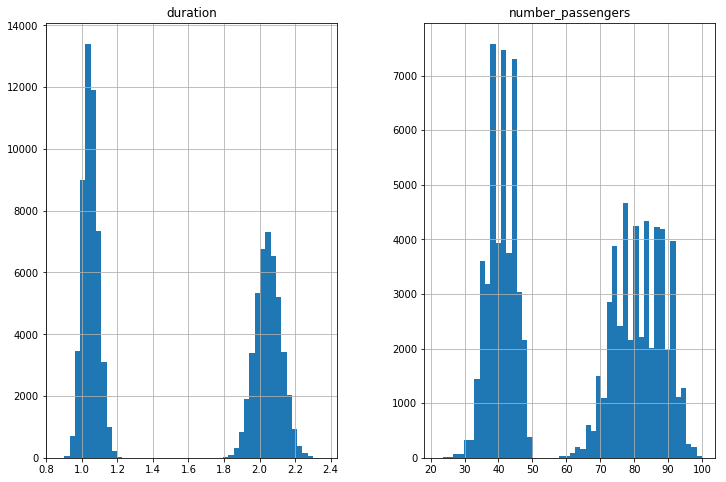

In [49]:
# histogramme des donnees de 1995 à 2016 pour la duree et
# le nombre de passagers
flights_with_pred[['number_passengers', 'duration']].\
hist(figsize=(12, 8), bins=50)

Nous remarquons ici plusieurs choses interessantes.
<ul>
<li> L'histogramme de gauche semble être constitué de deux groupes distinct pouvant être assimilé à des distributions gaussiennes.<br> L'un centré autour des <b>1h</b> de vol et l'autre autour des <b>2h</b> de vol.
<br> Aussi, la durée maximum des vols est inférieur à <b>2.5 heures</b>.
<li> Concernant l'histogramme de droite, la même chose peut être noté. En effet, nous observons deux groupes distincts.<br> Le premier est centré autour des <b>40 passagers</b> tandis que le second quant à lui est centré autour de <b>80 passagers</b>. <br>Le nombre de personnes maximum n'excède pas 100 personnes.
</ul>
<br> Compte tenu de ces resultats et des spécifications des appareils données, nous aurions besoin à priori d'avions de type <b>A</b> et <b>B</b>. Cependant un nombre de passagers supérieur à 50 pour une durée de vol plus grande que 1.5 heures pourrait nous faire recourir à des avions de type <b>C</b>.

In [50]:
flights_type_A = flights_with_pred.\
                 query('duration<=1.5 & number_passengers<=100')
flights_type_B = flights_with_pred.\
                 query('duration<=2.5 & number_passengers<=50')
# cas ou l'on ne pourrait pas aller dans A (cause duree) et dans B (cause passager)
flights_not_A_nor_B = flights_with_pred.\
                      query('duration>1.5 & number_passengers>50')
print('nombre vols type A: {}'.\
      format(len(flights_type_A)))
print('nombre vols type B: {}'.\
      format(len(flights_type_B)))
print('nombre vols non A et non B: {}'.\
      format(len(flights_not_A_nor_B)))

nombre vols type A: 50232
nombre vols type B: 44616
nombre vols non A et non B: 0


In [83]:
flights_with_pred.shape

(94847, 14)

In [84]:
# vols pouvant etre exclusivement effectués par des avions de type A
flights_exclusifs_type_A = flights_with_pred.\
                           query('duration<=1.5 & \
                                 number_passengers>50 & \
                                 number_passengers<=100')
#vols pouvant être effectués exclusivement par des avions de type B
flights_exclusifs_type_B = flights_with_pred.\
                           query('duration>1.5 & \
                                  duration<=2.5 & \
                                  number_passengers<=50')
# cas ou l'on ne pourrait pas aller dans A (cause duree) et dans B (cause passager)
print('nombre vols exclusifs type A: {}'.\
      format(len(flights_exclusifs_type_A)))
print('nombre vols exclusifs type B: {}'.\
      format(len(flights_type_B)))
print('nombre total de vols: {}'.\
      format(len(flights_with_pred)))

nombre vols exclusifs type A: 50231
nombre vols exclusifs type B: 44616
nombre total de vols: 94847


Nous avons ici donc les vols pouvant n'être effectués exclusivement par A ou par B et leur somme
est egal au nombre total de vols, ce qui est interessant pour la suite.
<br> Par le terme <b>exclusif</b>, j'entends un vol ne pouvant qu'être executé par un avion de type
<b>A</b> ou <b>B</b> et non pas par les 2.
<br>Nous n'avons ici pas besoin d'avions de type <b>C</b>. En effet,  les avions de type A et B suffisent.




#### Quelques visualisations utiles pour sur les données de vol qui nous aiderons dans nos recherches
Nous essayerons ici à l'aide de visualisations de repondre à quelques questions.
<ul>
<li> 1.<b>Y'a t'il eu une augmentation du traffic tout au long des années?</b>
<li> 2.<b>Y'a t'il plus de vols les jours de semaine que les week end?</b>
<li> 3.<b>Y'a t'il plus de vols dans une saison comparée à une autre?</b>
</ul>

### Augmentation du traffic?
Nous allons essayer ici de voir si une augmentation du trafic est survenue au cours des differentes années

(1995, 2016)

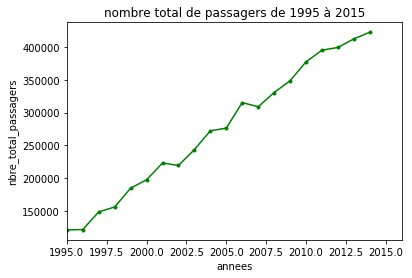

In [85]:
# nombre total de passagers par an
nb_passengers_per_year = flights_with_pred.groupby('year')\
                         ['number_passengers'].sum()
plt.figure(num=0)
plt.plot(nb_passengers_per_year.index[:-2],
         nb_passengers_per_year.values[:-2],
         'g-',
         marker=".")
plt.title('nombre total de passagers de 1995 à 2015')
plt.xlabel('annees')
plt.ylabel('nbre_total_passagers')
plt.xlim(1995, 2016, 1)

L'année <b>2016</b> ne contenant des données que sur le 1 janvier, je n'en est pas tenu compte dans la creation de ce graphique.
<br> Il est clair ici que la tendance global est la hausse. En effet, au fur à mesur des années, nous observons de plus en plus de passagers transportés par notre compagnie aerienne et ce malgré de legères stagnations ou baisse notamment entre 2006 et 2007 et entre 2001 et 2002.
<br> Le nombre de voyageurs de la compagnie est donc en constante evolution. Dans les faits, nous sommes passés d'un peu moins de <b>145000</b> passagers  transportés en <b>1995</b> à plus de <b>400.000</b> aujourd'hui, soit une augmentation de plus de 100% du trafic en un peu plus de 25 ans.

###  Y'a t'il plus de vols les weeks ends que les jours de semaine?

In [86]:
#mettre dans une dataframe le nombre de vols par jour et par annee
flights_per_day = flights_with_pred.groupby(['year', 'day_name']).\
                  size().unstack()

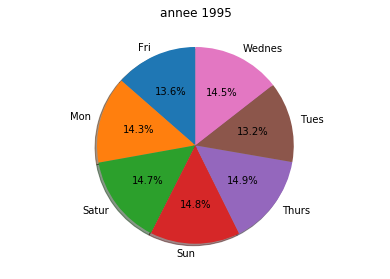

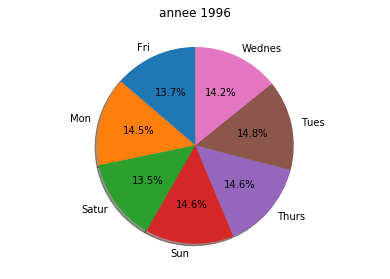

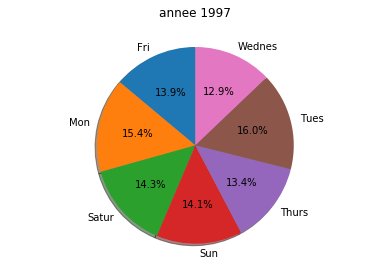

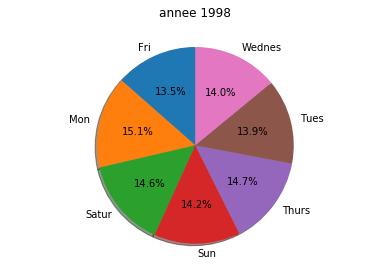

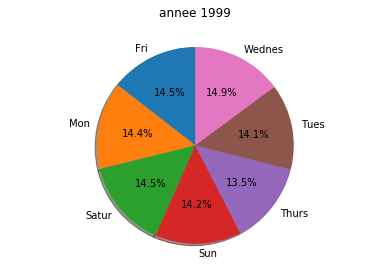

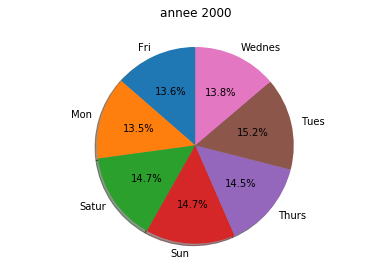

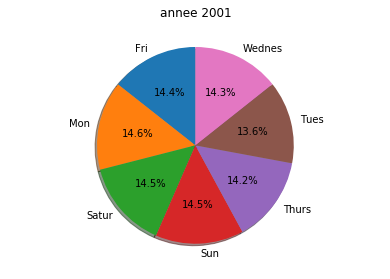

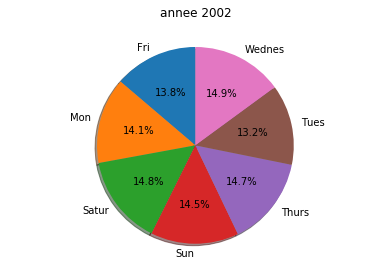

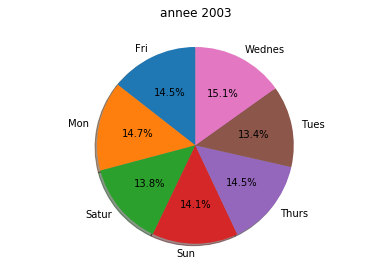

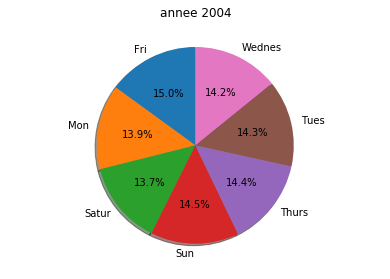

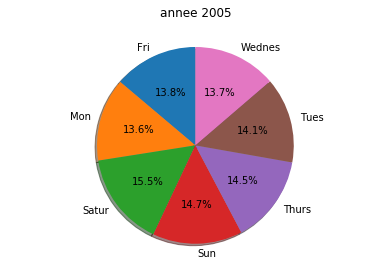

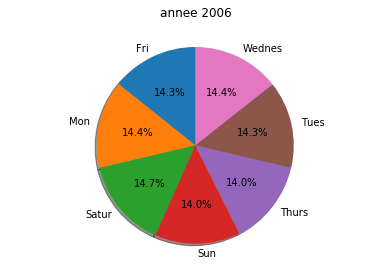

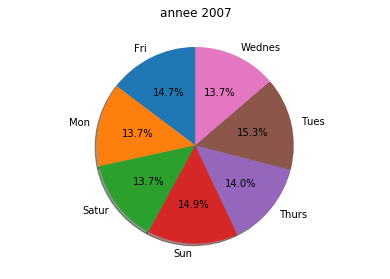

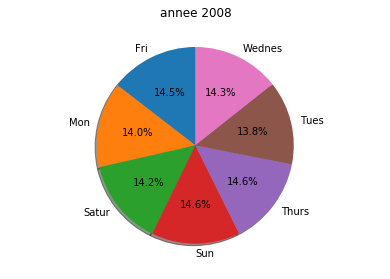

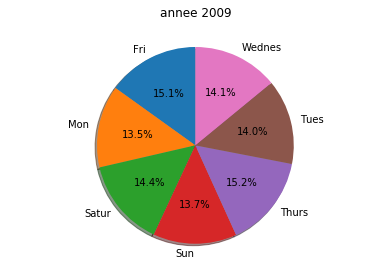

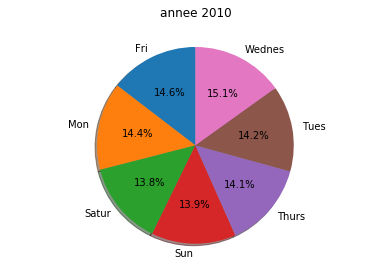

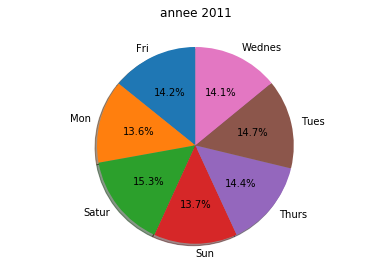

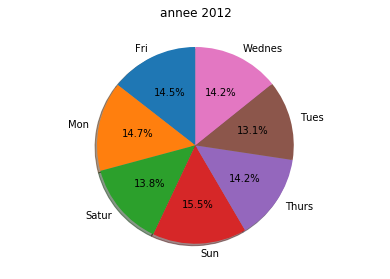

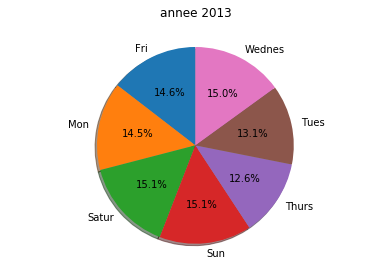

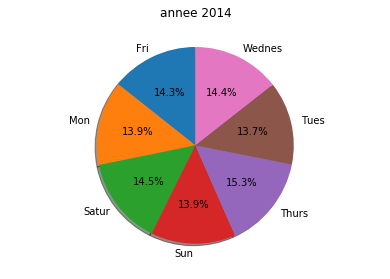

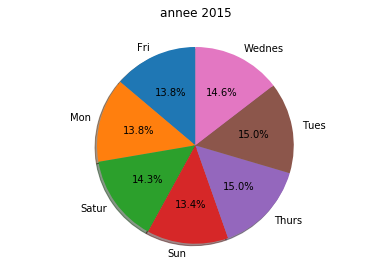

In [87]:

def plot_pie(data, year):
    """ 
    plot a pie chart of flights on the days
    for a specific year
    INPUT
    -data: dataframe concerned
    -year : year for computing data
    OUTPUT
    - return a pie chart
    """
    assert year>=1995 and year<=2015, 'année non presente'
    fig, axs = plt.subplots()
    data_to_use = data.loc[year,:]
    labels = data_to_use.index
    sizes = data_to_use.values

    axs.axis('equal')  
    plt.tight_layout()
    axs.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    axs.set_title('annee '+str(year))

# diagramme materialisant la quantité de vols par jour
# et par année.
for year in range(1995,2016):
    plot_pie(flights_per_day, year)

Une equirepartition du nombre d'arrivée de vols par jour donnerait environ <b>14.28%</b> dans chaque subidivision.
<br> Un rapide parcours des differents graphiques de <b>1995</b> à <b>2016</b> nous montre que les arrivées des vols suivant les jours et les années semblent equirepartis. Il n'y a pas plus de traffic les week ends que les jours de semaines.

#### Y'a t'il plus de passagers voyageant les weeks ends?

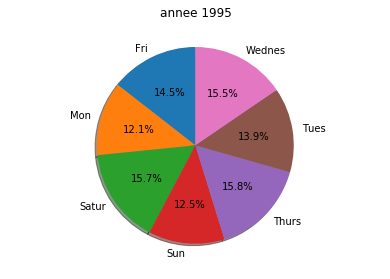

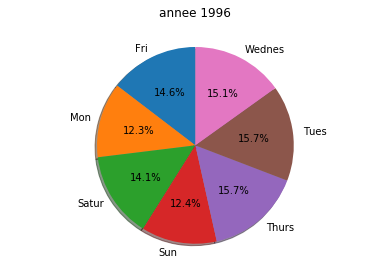

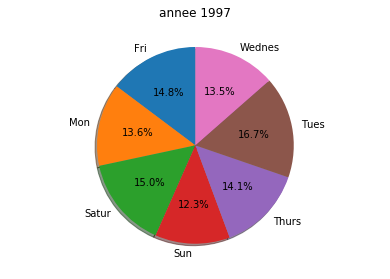

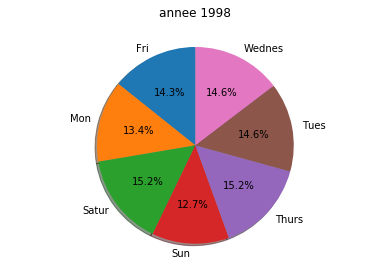

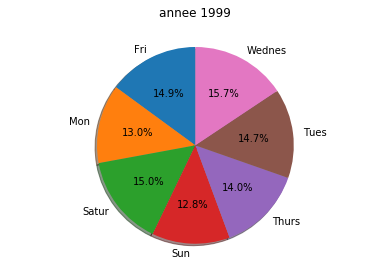

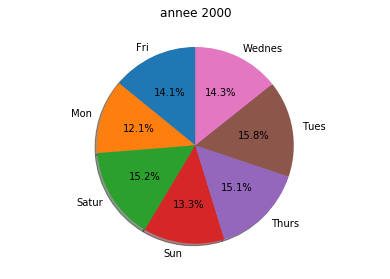

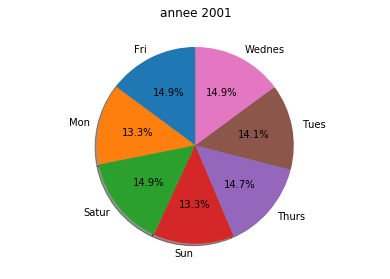

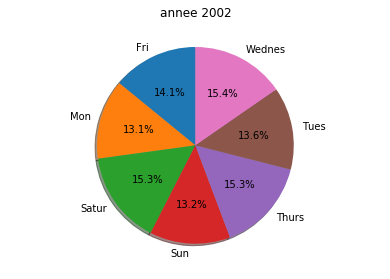

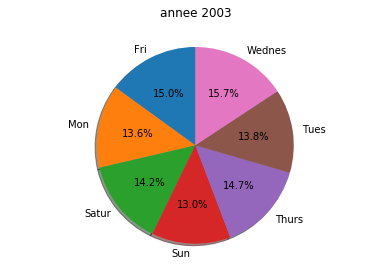

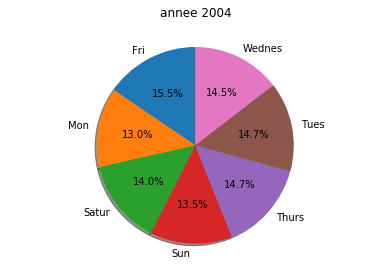

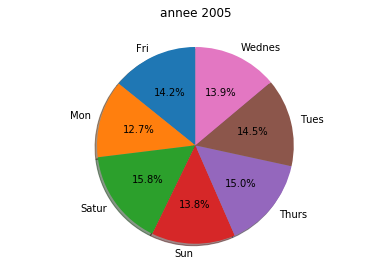

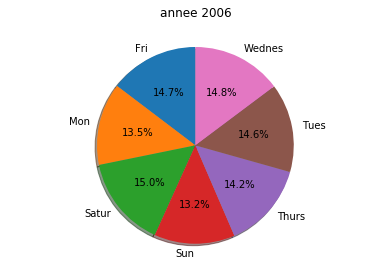

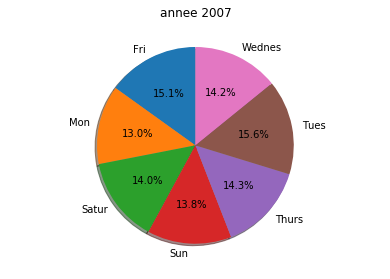

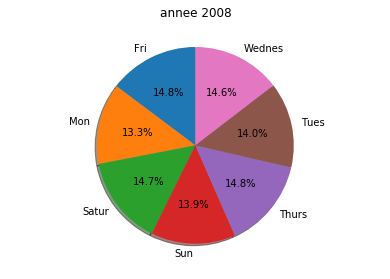

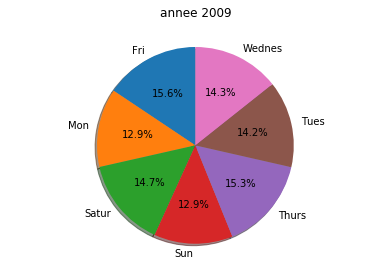

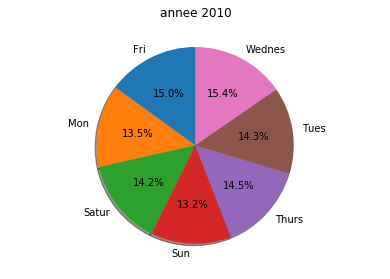

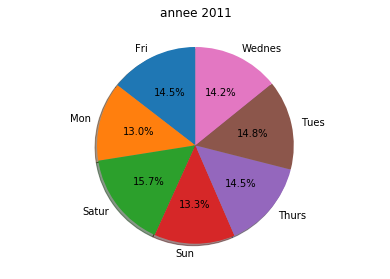

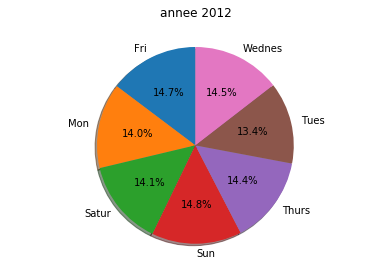

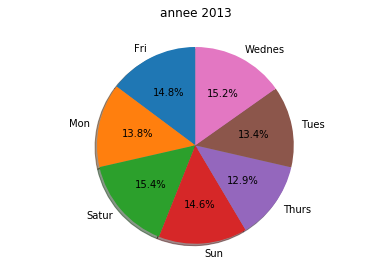

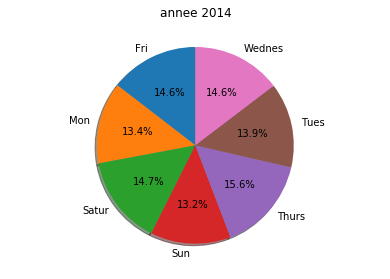

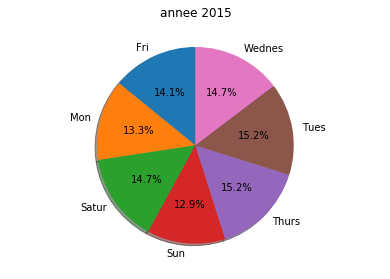

In [55]:
people_per_day = flights_with_pred.groupby(['year', 'day_name'])\
                 ['number_passengers'].sum().unstack()
for year in range(1995,2016):
    plot_pie(people_per_day, year)

La conclusion est la meme ici. En effet le nombre de voyageurs suivant les jours de 1995 à 2015 semblent équirepartis suivant les semaines. Il y'a de legères fluctuations mais pas assez significatives pour valider cette hypothèse. Il n'y a donc pas plus de voyageurs voyageant les week end et cette tendance semble se consolider suivant les années.

#### Y'a t'il plus de vols dans une saison particulière au fil des années?

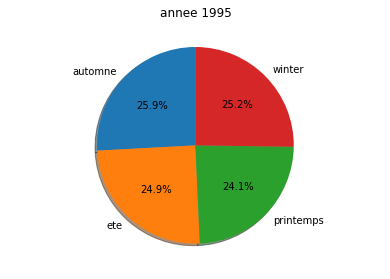

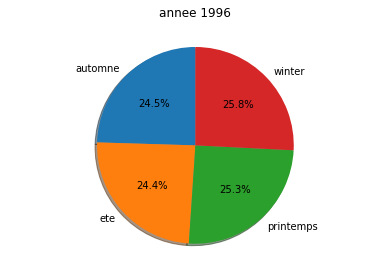

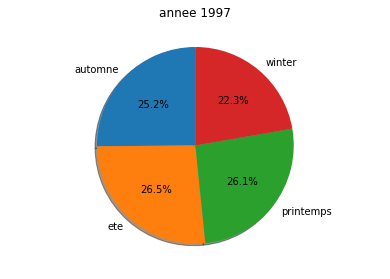

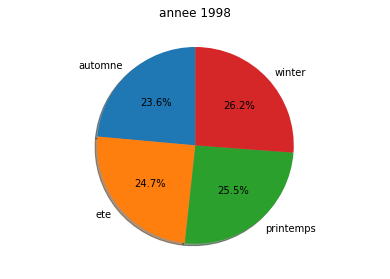

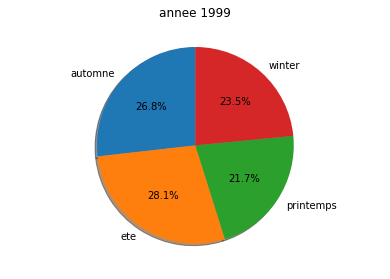

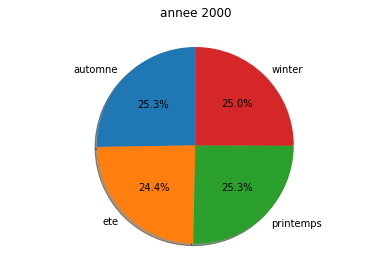

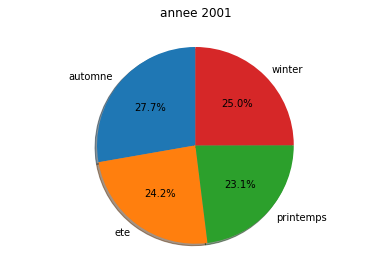

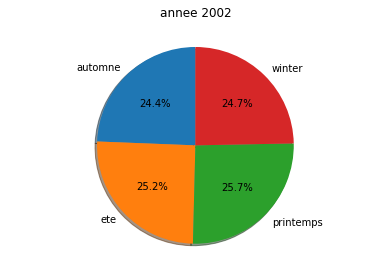

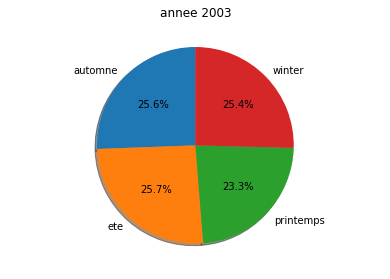

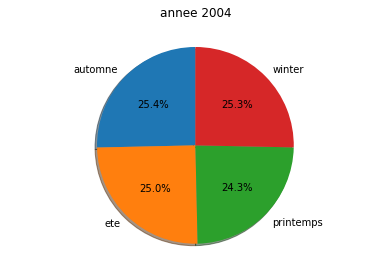

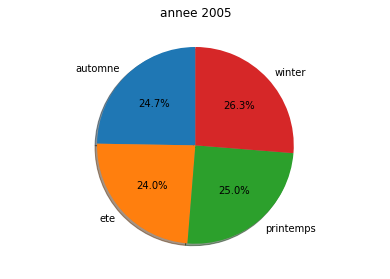

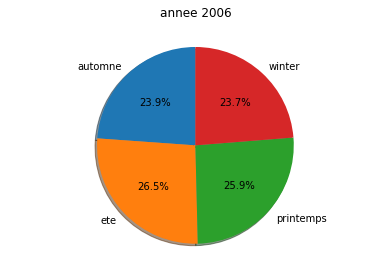

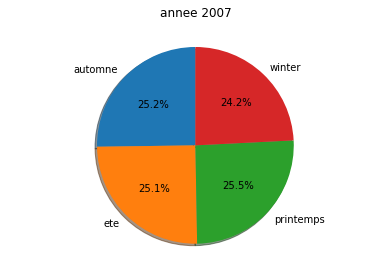

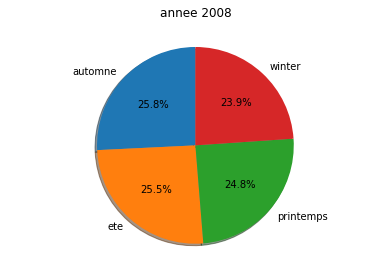

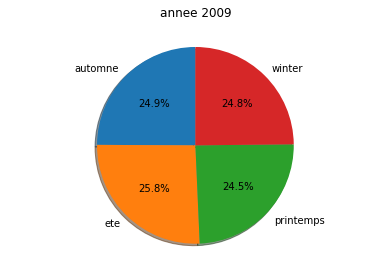

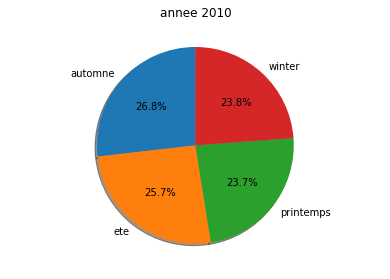

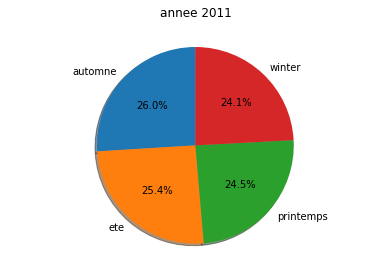

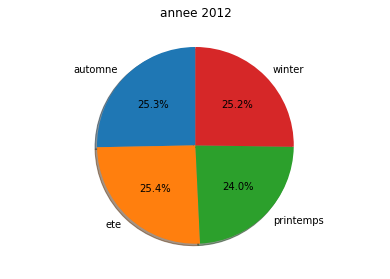

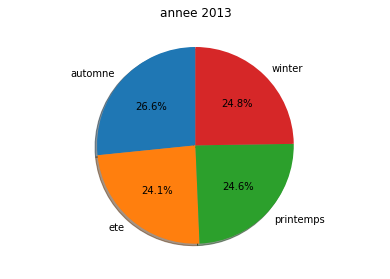

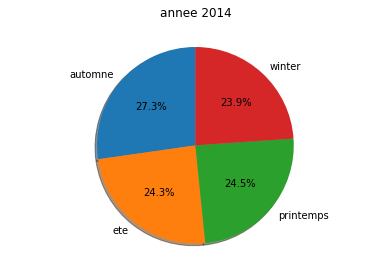

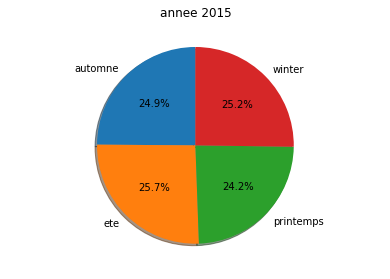

In [56]:
flights_per_season = flights_with_pred.groupby(['year', 'season']).\
                     size().unstack()
for year in range(1995,2016):
    plot_pie(flights_per_season, year)

Une visualisation rapide de l'ensemble des graphiques allant de <b>1995</b> à <b>2016</b> nous montre que le nombre de vols est equilibrée suivant les saisons et suivant les années. Il n'ay vraisemblablement pas plus de vol sur une saison en particulier comparé à une autre.

#### Y'a t'il plus de passagers dans une saison particulière au fil des années?

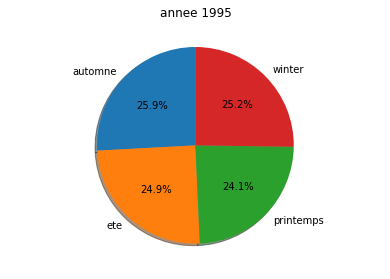

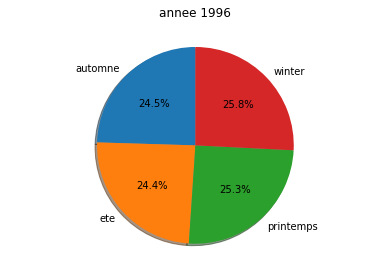

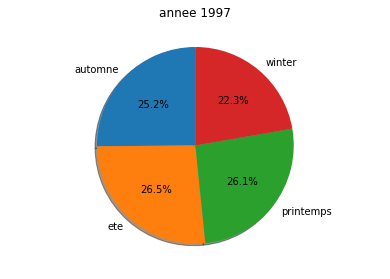

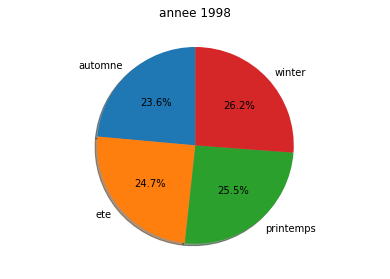

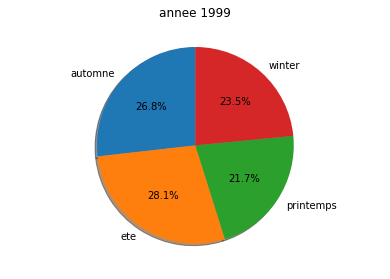

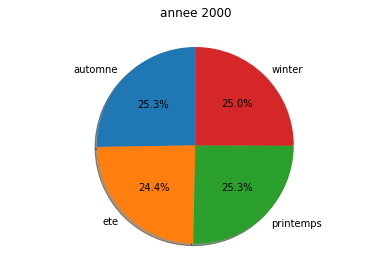

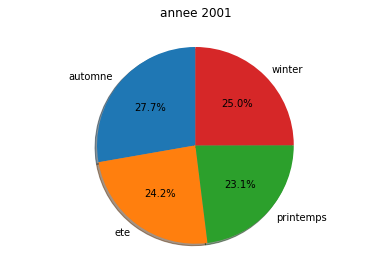

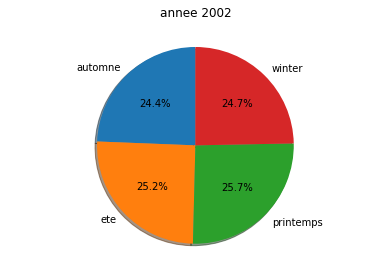

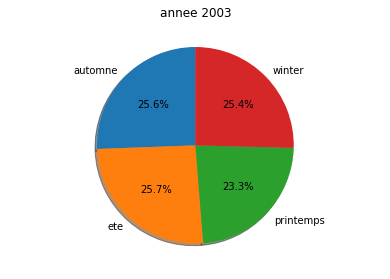

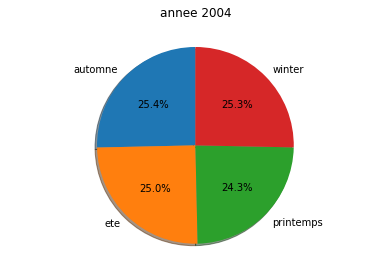

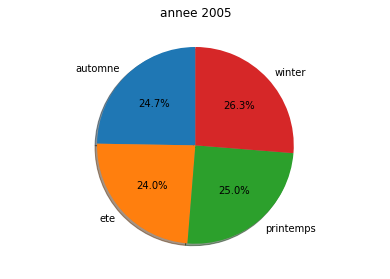

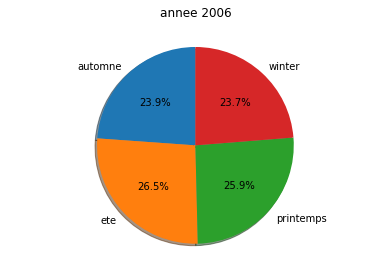

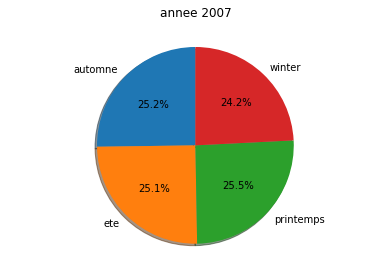

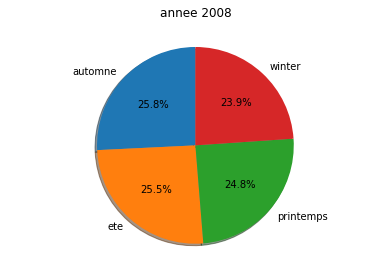

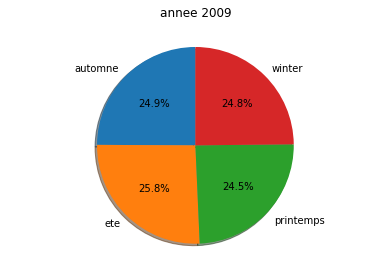

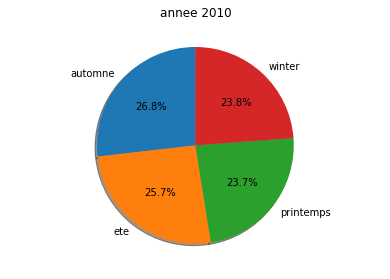

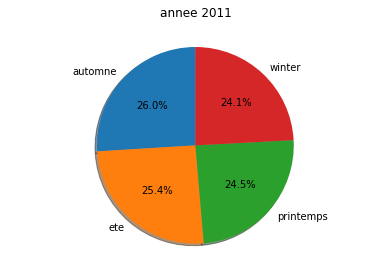

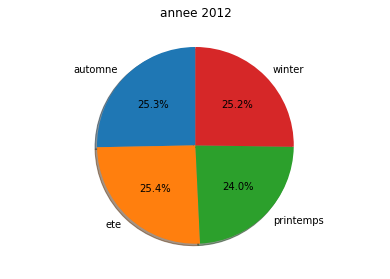

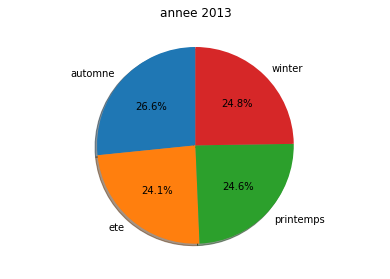

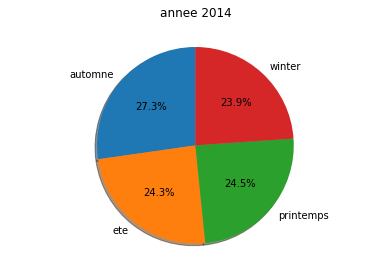

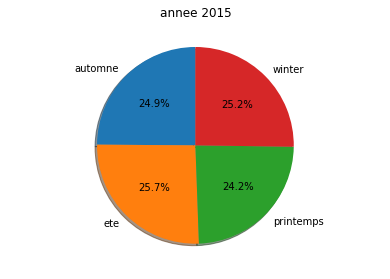

In [57]:
people_per_season = flights_with_pred.groupby(['year', 'season'])['number_passengers'].sum().unstack()
for year in range(1995,2016):
    plot_pie(flights_per_season, year)

In [58]:
people_per_season

season,automne,ete,printemps,winter
year,,,,
1995,29897.0,32996.0,29974.0,27767.0
1996,28687.0,32651.0,31392.0,28508.0
1997,36444.0,42324.0,39532.0,29871.0
1998,35495.0,42424.0,40239.0,37501.0
1999,47953.0,56022.0,41134.0,39373.0
2000,48589.0,52721.0,51039.0,44900.0
2001,60699.0,58987.0,53137.0,50115.0
2002,52080.0,60432.0,57843.0,48803.0
2003,60469.0,67862.0,58701.0,56342.0


Un parcours rapide des differents diagrammes revèle que le nombre de passagers suivant les saisons au fil des années est equilibré.
<br> Il n'ya donc pas une difference sensible du nombre de voyageurs suivant les saisons et ce au fil des années.

#### CONCLUSION
<ul>
<li> Le traffic en terme de nombre de vols de la compagnie a evolué entre 1995 et 2015 (hausse d'année en année)
<li> Il n y'a pas plus de vols les weeks ends qu'en semaine, idem pour le nombre de 
passagers et cette tendance reste verifié entre 1995 et 2015.
<li>Il n y'a pas plus de vols dans une saison particulière relativement à une autre, idem pour le nombre de 
passagers et cette tendance reste verifié entre 1995 et 2015.
</ul> 

### Composition en % d'avions de type A et B pour effectuer les vols journaliers entre 1995 et 2015.

In [59]:

# Quel est le nombre d'avions de type A est utilisé par année?
flights_type_A_year = flights_exclusifs_type_A. \
                      groupby(['date']).size()
# Quel est le nombre d'avions de type B est utilisé par année?
flights_type_B_year = flights_exclusifs_type_B.\
                      groupby(['date']).size()
# Quel est le nombre de vols sur ces années?
flights_with_pred_tot = flights_with_pred.\
                        groupby(['date']).size()
# Pourcentage des vols de type A 
percentage_vol_A = (flights_type_A_year\
                    /flights_with_pred_tot)*100
percentage_vol_B = (flights_type_B_year\
                    /flights_with_pred_tot)*100

print('moyenne de A : {}'.\
      format(np.nanmean(percentage_vol_A.values)))
print('std de A : {}'.\
      format(np.nanstd(percentage_vol_A.values)))
print('moyenne de B : {}'.\
      format(np.nanmean(percentage_vol_B.values)))
print('std de B : {}'.\
      format(np.nanstd(percentage_vol_B.values)))

moyenne de A : 53.541819403329136
std de A : 9.435802098034607
moyenne de B : 46.50746531699028
std de B : 9.473535147136069


En moyenne sur la journée et entre 1995 et 2015, le nombre de vols pouvant exclusivement  s'effectuer 
avec des avions de type <b>A</b> est de 54% environ contre 46 pour le type</b>.
<br> L'ecart type étant relativement grand, ces valeurs ne sont pas stables et fluctuent beaucoup d'un jour à l'autre.

### Composition en % d'avions de type A et B pour effectuer les vols mensuels entre 1995 et 2015.

In [60]:

# Quel est le nombre d'avions de type A est utilisé par année?
flights_type_A_year = flights_exclusifs_type_A.\
                      groupby(['year', 'month']).size()
# Quel est le nombre d'avions de type B est utilisé par année?
flights_type_B_year = flights_exclusifs_type_B.\
                      groupby(['year', 'month']).size()
# Quel est le nombre de vols sur ces années?
flights_with_pred_tot = flights_with_pred.\
                        groupby(['year', 'month']).size()
# Pourcentage des vols de type A 
percentage_vol_A = (flights_type_A_year\
                    /flights_with_pred_tot)*100
percentage_vol_B = (flights_type_B_year\
                    /flights_with_pred_tot)*100


print('moyenne de A : {}'.\
      format(percentage_vol_A.values.mean()))
print('std de A : {}'.\
      format(percentage_vol_A.values.std()))
print('moyenne de B : {}'.\
      format(percentage_vol_B.values.mean()))
print('std de A : {}'.\
      format(percentage_vol_A.values.std()))

moyenne de A : 53.532402289155584
std de A : 1.8271642667425279
moyenne de B : 46.466322688531534
std de A : 1.8271642667425279


En moyenne sur le mois et entre 1995 et 2015, le nombre de vols pouvant exclusivement  s'effectuer 
avec des avions de type <b>A</b> est de 54% environ contre 46 pour le type</b>.
<br> L'ecart type étant ici beaucoup plus faible comparé à la journée, ce qui denote une relative stabilité
de cette moyenne au cours des differents mois durant ces 20 ans.

#### Voyons maintenant le nombre de vols par annee et son evolution de 1995 à 2016

In [88]:
# regroupons les donnees concernant le nombre de vols suivant l'annee et le jour 
vol_jour_par_an = flights_with_pred.\
                  groupby(['year', 'date']).size()
# effectuons une moyenne afin d'obtenir le nombre moyen de vols par jour par année
vol_moyen_par_annee = vol_jour_par_an.\
                      groupby('year').mean()
# regardons l'ecart type afin de verifier si les vols flucutuent d'un jour à un autre
# dans l'annee
std_vol_moyen_par_annee = vol_jour_par_an.\
                          groupby('year').std()

On remarque que l'ecart type est assez faible ici (compris entre 0 et 1), ce qui fait que le nombre de vols par jour ne varie pas bcp d'un jour à l'autre dans une meme année.
<br> Nous remarquons aussi que le nombre de vols journaliers augmente chaque année (trafic bcp plus important d'année en année).
<br> <b> Seconde remarque</b>: La tendance du nombre de vol moyen par année semble linéaire.  Nous allons donc
    ici predire le nombre de vol par année (année>2015) avec un modele lineaire.
<br> 

Text(0.5,1,'nombre moyen de vol par annee + ecart type')

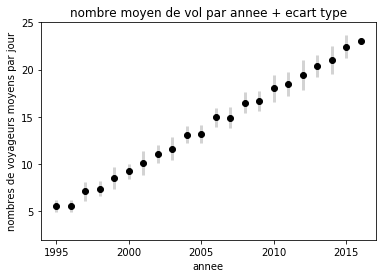

In [89]:
# années allant de 1995 à 2016
x = std_vol_moyen_par_annee.index
# valeurs du nombre de vols moyens par années
y = vol_moyen_par_annee.values
#ecart type sur la moyenne de l'année
dy = std_vol_moyen_par_annee.values

plt.errorbar(x, y, yerr=dy, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
plt.ylim(2,25,5)
plt.xlabel('annee')
plt.ylabel('nombres de voyageurs moyens par jour')
plt.title('nombre moyen de vol par annee + ecart type')

L'écart type sur la moyenne du nombre de vol journalier étant assez faible (compris entre 0 et 1).
On peut supposer notre estimation du nombre de vols quotidien fiable.
<br> Aussi la tendance entre 1995 et 2015 est à la croissance, ce qui laisse auguré
une augmentation du trafic pour les années suivant 2015. Nous predirons donc ce nombre de vol moyens en nous
servant des données de cette courbe.

In [66]:

def predict_daily_travellers(year):
    """ 
    predire pour les annees>2015,
    le nombre journalier moyen de
    vols
    INPUT
    -data: annee : >2015

    OUTPUT
    - return une estimation 
    du nombre de vols pour
    l'année.
    """
    # verifier que l'annee est superieur à 2015
    assert year>2015, 'erreur annee doit etre>=2016'
    # instancier un modèle lineaire
    lin_reg = LinearRegression()
    X = np.array(vol_moyen_par_annee.index).reshape(-1,1)
    #l'entrainer
    lin_reg.fit(X,
                np.asarray(vol_moyen_par_annee.values)
               )
    #retourner la prediction
    return np.round(lin_reg.predict([[year]]))[0]


#### Calcul du nombre d'avions necessaires
Emettons les hypothèses et les simplifications suivantes pour simplifier notre calcul:
<ul>
<li> Nous dirons pour simplifier que les vols du dataset sont à destination de <b>"Y"</b>.
Notre <b>aeroport</b> est donc <b>Y</b>.
<li> Les vols en provenance d'une destination <b>X</b> vers <b>Y</b> repartent vers <b>X</b>
après une période de repos et une reprise de passagers à <b>Y</b>.
<li> Notre aeroport <b>Y</b> est ouvert chaque jour de 5h à 23h. Ce qui fait une periode de fonctionnement de 17h.
<li> Les avions (type A ou B) ont 1 heure de rotation à chaque vol, ce qui veut dire qu'un avion peut effectuer dans une même journée plusieurs vols de <b>X</b> vers <b>Y</b> et de <b>Y</b> vers <b>X</b>.
<li>  Le nombre de vols moyens effectués par la compagnie par mois varie très peu (dans la même année)et donne en terme de composition 54% d'avions de type A et 46% d'avions de type B (on supposera ici que les tendances regulières observés  sur les mois d'une même année (entre 1995 et fin 2015) concernant la composition en % d'avion de type A et B  pour les vols se verifie aussi pour les journées futures et une destination precise (<b>hypothèse forte</b>))
</ul>
 Un avion de type <b>A</b> a une autonomie de vol de 1.5 h (durée maximum). En supposant 1h de temps de rotation à chaque vol, cela fait 2.5h pour chaque vol. Nous avons donc
17/2.5 = 6.8 vols possibles (aller-retour entre <b>X</b> et <b>Y</b> possibles).
<br> En effectuant un raisonnement analogue pour les avions de type <b>B</b>, nous obtenons 17/3.5 = 4.8
<br> Afin de palier à certains paramètres negligés pouvant impacter le temps de rotation, nous allons ici selectionner 6 vols possibles (aller-retour) pour l'avion de type <b>A</b> et 4 vols possibles (allers-retours) pour l'avion de type B.
<br> Nous ne savons connaissons pas le nombre de provenance exacte des avions pour la destination <b>Y</b>.
Cependant,  dans le pire des cas, il y'a autant de provenances differentes que de vols et dans le meilleur des cas une provenance et une seule destination (<b>Y</b>).
<br> La fonction ci dessous calcule la composition de la flotte pour ce cas trivial et le pire cas.
<br> Pour le pire cas avec autant de provenances que de vols, le nombre d'avions necessaires dans la journée est egale au nombre de vols émis compte tenu de nos hypothèses (trajet d'un vol en provenance de X1 ne peut repartir que vers X1).
<br> Pour le cas idéal, le calcul est effectué par la fonction ci dessous et donne 10 avions.
<br> Il n'y a donc pas de reponses exactes à cette question car la donnée concernant le nombre de provenances manquent. On ne peut donner qu'un intervalle d'avions necessaire [<b>cas ideal</b>, <b>pire cas</b>]
<br> Dans le cas de l'année 2016 => nbre d'avions journaliers compris entre 10 et 23.

In [67]:
def caluler_composition_flotte_cas_1_1(year):
    """ 
    calculer la composition de notre
    flotte en terme d'avions de type
    A et B pour le cal trivial 1
    provenance pour tout les vols
    et 1 destination
    vols
    INPUT
    -data: annee : >2015

    OUTPUT
    - return composition de la flotte
    aerienne pour cette destination
    et les les differentes provenances.
    """
    # calculer le nombre de vols journier
    # en se basant sur la tendance lineaire
    vol_journalier = predict_daily_travellers(year)
    print('vol_journalier:', vol_journalier)
    type_A = np.round(0.54*vol_journalier)
    type_B = np.round(0.46*vol_journalier)
    print('type A',type_A)
    print('type B',type_B)
    nbre_avions_A = np.ceil(type_A/3)
    nbre_avions_B = np.ceil(type_B/2)
    return {'avions A':nbre_avions_A,'avions B':nbre_avions_B}

def caluler_composition_flotte_cas_pire_cas(year):
    """ 
    calculer la composition de notre
    flotte en terme d'avions de type
    A et B pour le cal trivial 1
    provenance pour tout les vols
    et 1 destination
    vols
    INPUT
    -data: annee : >2015

    OUTPUT
    - return composition de la flotte
    aerienne pour cette destination
    et les les differentes provenances.
    """
    # calculer le nombre de vols journier
    # en se basant sur la tendance lineaire
    vol_journalier = predict_daily_travellers(year)
    print('vol_journalier:', vol_journalier)

    nbre_avions_A = np.ceil(0.54*vol_journalier)
    nbre_avions_B = vol_journalier-nbre_avions_A
    return {'avions A':nbre_avions_A,'avions B':nbre_avions_B}

In [68]:
print('meilleur cas \n',
      caluler_composition_flotte_cas_1_1(2016))
print("=====================================")
print('pire cas \n',
      caluler_composition_flotte_cas_pire_cas(2016))

vol_journalier: 23.0
type A 12.0
type B 11.0
meilleur cas 
 {'avions A': 4.0, 'avions B': 6.0}
vol_journalier: 23.0
pire cas 
 {'avions A': 13.0, 'avions B': 10.0}


Le nombre d'avions dont a besoin notre compagnie aerienne pour effectuer des vols entre <b>Y</b> et les X destinations de départ est donc de 10.
<br> Si on suppose ici 23 vols journaliers à destinations de Y, 